In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import seaborn as sns
import sklearn as sk
import os
import nltk
from nltk.data import find
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from contextlib import redirect_stdout
import statistics
import pickle
%run -i ./Model_Eval.ipynb

2023-02-17 00:12:53.577264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 00:12:53.669096: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 00:12:54.084372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tychi/miniconda3/lib/
2023-02-17 00:12:54.084447: W tensorflow/compiler/xla/stre

In [2]:
from transformers import BertTokenizer, TFBertModel

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

2023-02-17 00:12:56.592645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-17 00:12:56.597249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-17 00:12:56.597508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-17 00:12:56.597784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

In [4]:
one_star_reviews = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv", nrows=500000)
# one_star_reviews = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv", nrows=5000)

In [5]:
lengths = [len(text.split(' ')) for text in one_star_reviews['full_text'].values if len(text.split(' ')) < 250]

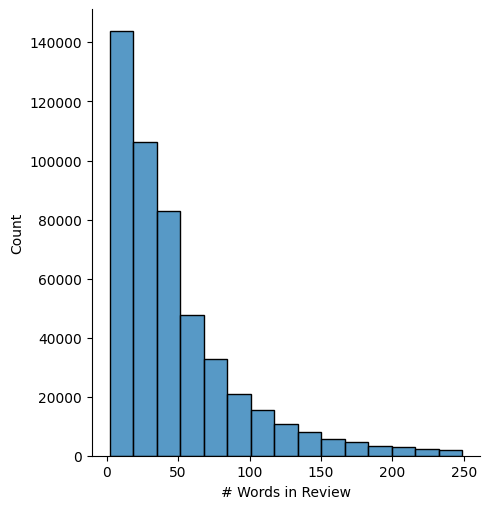

In [6]:
sns.displot(lengths, bins=15)
plt.xlabel('# Words in Review')
plt.show()

## Should be able to cap tokenizer length at 50, to reduce the window for CNN layers to convolve over.

In [7]:
max_length = 50

In [8]:
train, test = train_test_split(one_star_reviews, test_size=0.33, random_state=42)

In [9]:
x_train = bert_tokenizer(train['full_text'].tolist(),
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = tf.convert_to_tensor(train['reviewer_avg_rating'])

In [10]:
x_test = bert_tokenizer(test['full_text'].tolist(),
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = tf.convert_to_tensor(test['reviewer_avg_rating'])

In [11]:
def build_bert_cnn_model(bert_model):
    bert_model.trainable = False
    # 3 BERT input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # assemble to pass into bert model
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)
    
    sequence_output = bert_out[0]
    
    cnn_layers = [bert_out[1]] # initialize it with the pooled output, see if that improves model performance.
    
    # determine these kernel/filters based on max_length
    kernel_sizes = [3,4,6]
    num_filters = [30,20,15]
    
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(sequence_output)
        pooling_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        cnn_layers.append(pooling_layer)
    
    conv_output = tf.keras.layers.concatenate(cnn_layers, axis=1)
    
    # 2 dense layers
    net = keras.layers.Dense(200, activation='relu')(conv_output)
    net = keras.layers.Dense(100, activation='relu')(net)
    net = keras.layers.Dropout(0.1, name='dropout_0.1')(net)
                         
    regression = keras.layers.Dense(1, activation='linear', name='prediction_layer')(net)
    cnn_model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=regression
    )
    
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005), # half of the normal learning rate
        loss='mean_squared_error'
    )
                         
    return cnn_model

In [12]:
cnn_model = build_bert_cnn_model(bert_model)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                              

In [13]:
from datetime import datetime
now = datetime.now()
import os

# just uniique directory name
current_time = now.strftime("%m_%d_%H")

model_dir = f"./Model_Results/{current_time}"

os.makedirs(f"./{model_dir}")

# save the model summary to a text file
with open(f'./{model_dir}/modelsummary.txt', 'x') as f:
    with redirect_stdout(f):
        cnn_model.summary()

filename=f'./{model_dir}/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [14]:
history = cnn_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    callbacks=[history_logger],
    batch_size=32,
    epochs=15
)

Epoch 1/15


2023-02-17 00:16:43.343789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-17 00:16:44.053897: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-17 00:16:44.145896: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x460c31b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-17 00:16:44.145925: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-02-17 00:16:44.149467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-17 00:16:44.234108: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-17 00:16:44.260292: I tensorflow/compiler/jit/xla_compilation_c

10469/10469 [==============================] - 1534s 146ms/step - loss: 1.4952 - val_loss: 1.1521
Epoch 2/15
10469/10469 [==============================] - 1513s 145ms/step - loss: 1.1682 - val_loss: 1.1546
Epoch 3/15
10469/10469 [==============================] - 1511s 144ms/step - loss: 1.1578 - val_loss: 1.1489
Epoch 4/15
10469/10469 [==============================] - 1514s 145ms/step - loss: 1.1472 - val_loss: 1.1571
Epoch 5/15
10469/10469 [==============================] - 1513s 145ms/step - loss: 1.1386 - val_loss: 1.1531
Epoch 6/15
10469/10469 [==============================] - 1512s 144ms/step - loss: 1.1316 - val_loss: 1.1535
Epoch 7/15
10469/10469 [==============================] - 1512s 144ms/step - loss: 1.1226 - val_loss: 1.1458
Epoch 8/15
10469/10469 [==============================] - 1512s 144ms/step - loss: 1.1164 - val_loss: 1.1541
Epoch 9/15
10469/10469 [==============================] - 1514s 145ms/step - loss: 1.1082 - val_loss: 1.1529
Epoch 10/15
10469/10469 [=====

In [15]:
# calculate final r2 scores, and save results
train_variance = statistics.variance(train['reviewer_avg_rating'])
test_variance = statistics.variance(test['reviewer_avg_rating'])

final_train_loss = history.history['loss'][-1]
final_test_loss = history.history['val_loss'][-1]

train_r2 = (train_variance - final_train_loss) / train_variance
test_r2 = (test_variance - final_test_loss) / test_variance

print(f'Train r2: {train_r2}')
print(f'Test r2: {test_r2}')

r2_scores = (train_r2, test_r2)

Train r2: 0.0319083224813566
Test r2: -0.05289855444643999


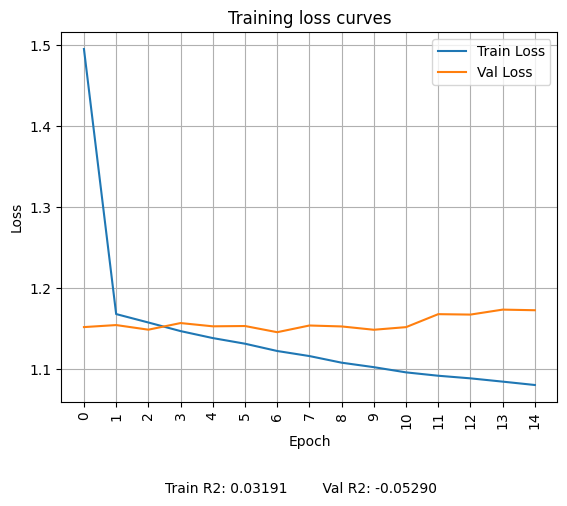

In [16]:
%run -i ./Model_Eval.ipynb
plot_loss(history, model_dir, r2_scores)